In [1]:
#importing libraries 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.pipeline import Pipeline
from SALib.sample.fast_sampler import sample as fast_sampler
from SALib.analyze.fast import analyze as fast_analyze
from SALib.analyze import fast


In [2]:
#Loading and reading the dataset
data = pd.read_csv('breast-cancer-wisconsin-data.csv')

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
#preprocessing data 
#droping id column and labalize diagnoses columns(1 for M and 0 for B)
data = data.drop(['id'], axis=1)
data.diagnosis = [1 if each == "M" else 0 for each in data.diagnosis]

# Separate features and target for model analysis
X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

# Split the dataset into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for PCA and model training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to reduce dimensionality while preserving 95% variance
pca = PCA(n_components=0.90, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check the number of components chosen by PCA
X_train_pca.shape[1]


7

In [4]:
#Correlation Matrix
correlation_matrix = X.corr()
correlation_matrix

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
fractal_dimension_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,...,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


In [5]:
#summary of the dataset
X.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


Number of cells labeled Benign:  357
Number of cells labeled Malignant :  212

% of cells labeled Benign 62.74 %
% of cells labeled Malignant 37.26 %


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


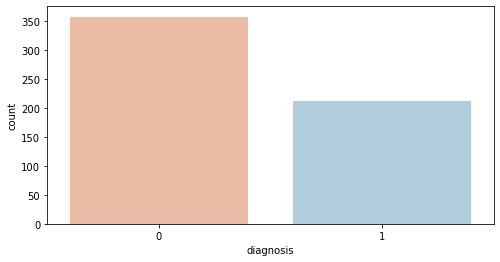

In [4]:
#Implying some visualizing graphs from the features of the dataset
#1 visualize distribution of classes 
plt.figure(figsize=(8, 4))
sns.countplot(data['diagnosis'], palette='RdBu')

# count number of obvs in each class
benign, malignant = data['diagnosis'].value_counts()
print('Number of cells labeled Benign: ', benign)
print('Number of cells labeled Malignant : ', malignant)
print('')
print('% of cells labeled Benign', round(benign / len(data) * 100, 2), '%')
print('% of cells labeled Malignant', round(malignant / len(data) * 100, 2), '%')

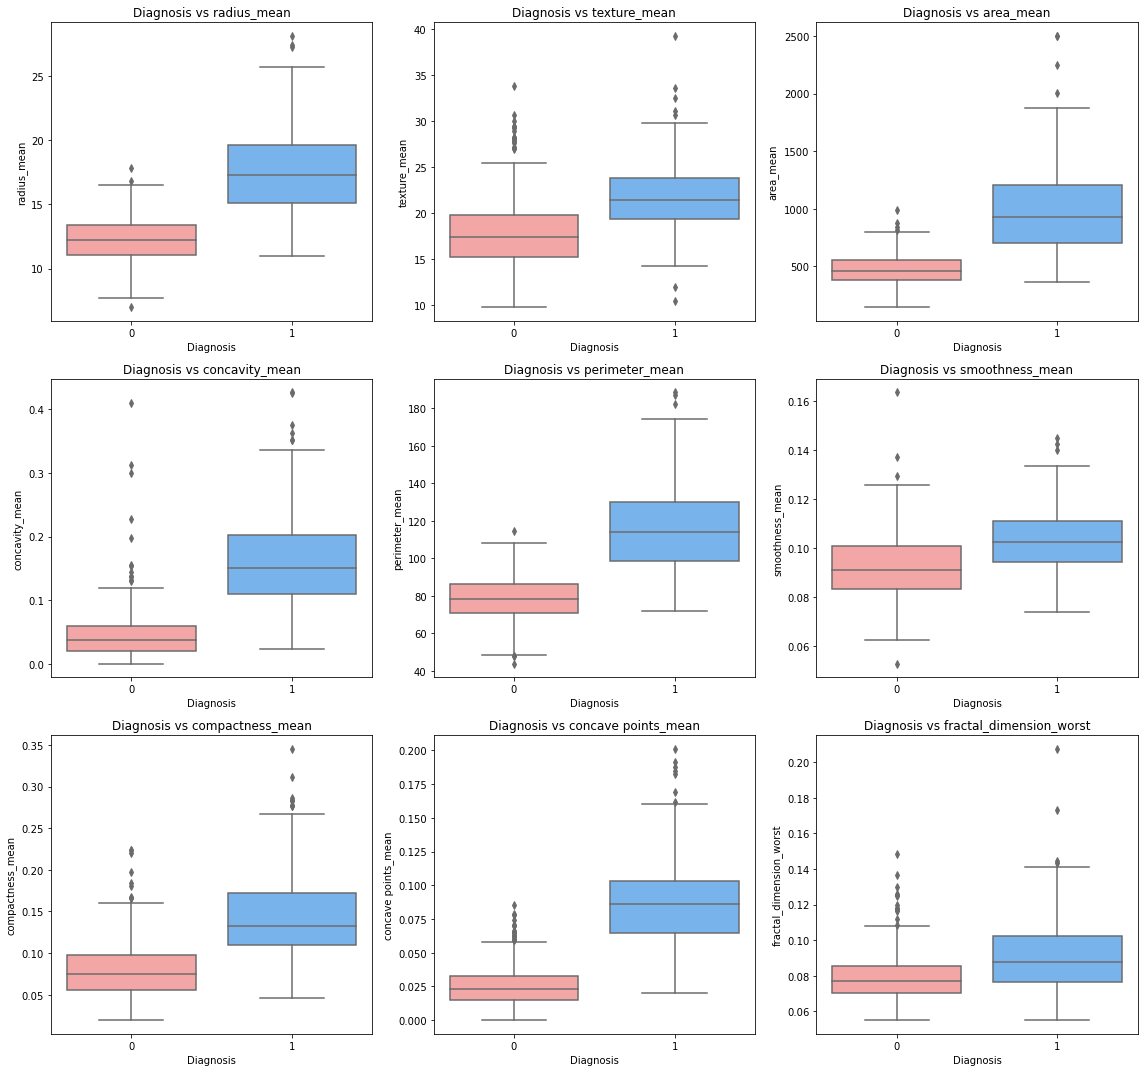

In [13]:
#2 Compare a few key features for malignant vs benign cases
features = ['radius_mean', 'texture_mean', 'area_mean', 'concavity_mean', 
            'perimeter_mean', 'smoothness_mean', 'compactness_mean','concave points_mean','fractal_dimension_worst']

# Calculate the number of rows and columns based on the number of features
n_features = len(features)
n_cols = 3  # Number of columns (you can adjust this)
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate the number of rows needed

plt.figure(figsize=(16, n_rows * 5))  # Adjust the figure size based on the number of rows

for i, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x='diagnosis', y=feature, data=data, palette=['#ff9999','#66b3ff'])
    plt.title(f'Diagnosis vs {feature}')
    plt.xlabel('Diagnosis')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

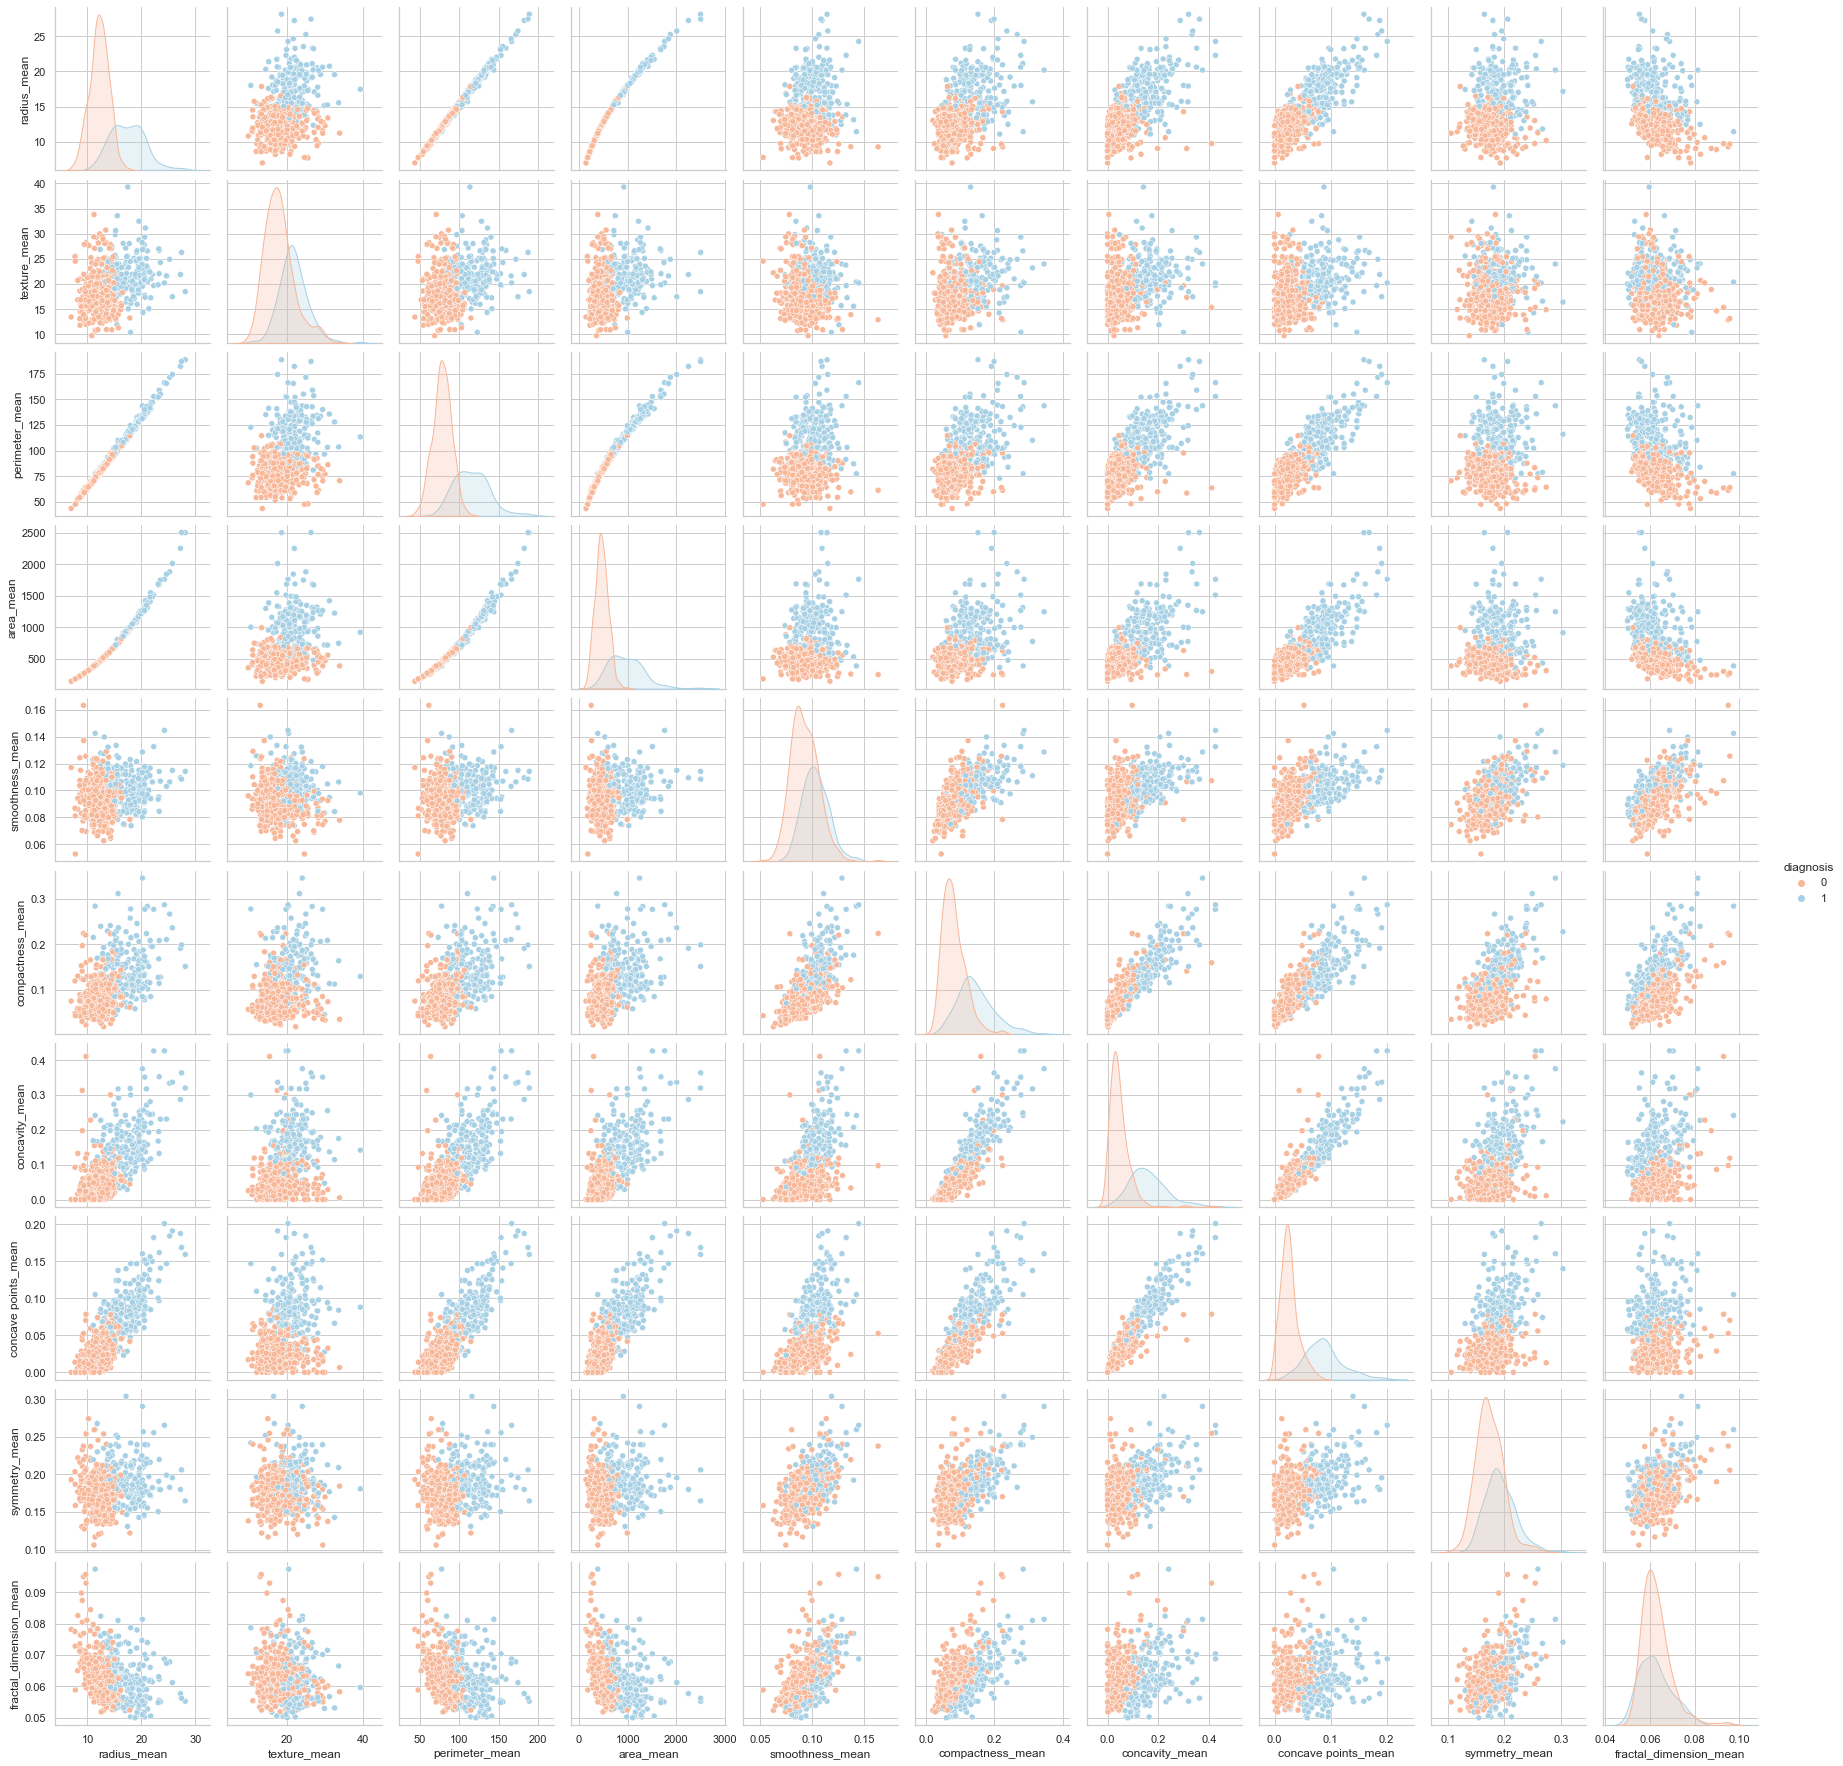

In [15]:
#3 generating a scatter plot matrix with the "mean" columns
cols = ['diagnosis',
        'radius_mean', 
        'texture_mean', 
        'perimeter_mean', 
        'area_mean', 
        'smoothness_mean', 
        'compactness_mean', 
        'concavity_mean',
        'concave points_mean', 
        'symmetry_mean', 
        'fractal_dimension_mean']

sns.pairplot(data=data[cols], hue='diagnosis', palette='RdBu')

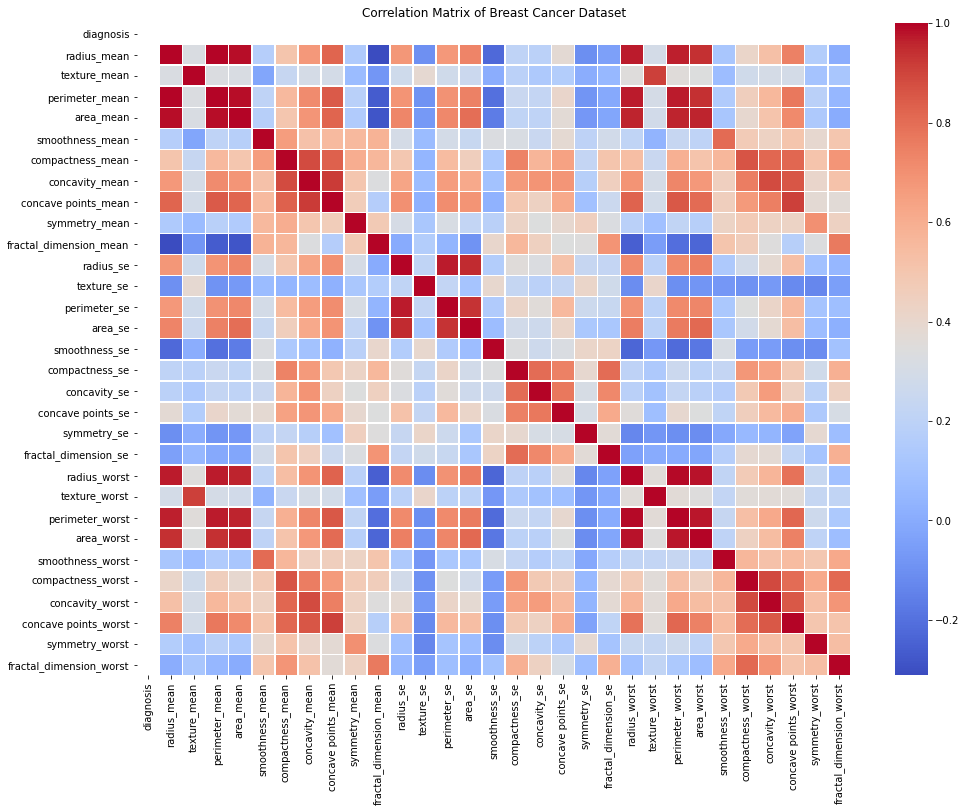

In [8]:
#4 generating a correlation matrix using a heatmap
# Encode 'diagnosis' as 1 for Malignant (M) and 0 for Benign (B)
data['diagnosis'] = data['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(16,12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Breast Cancer Dataset')
plt.show()

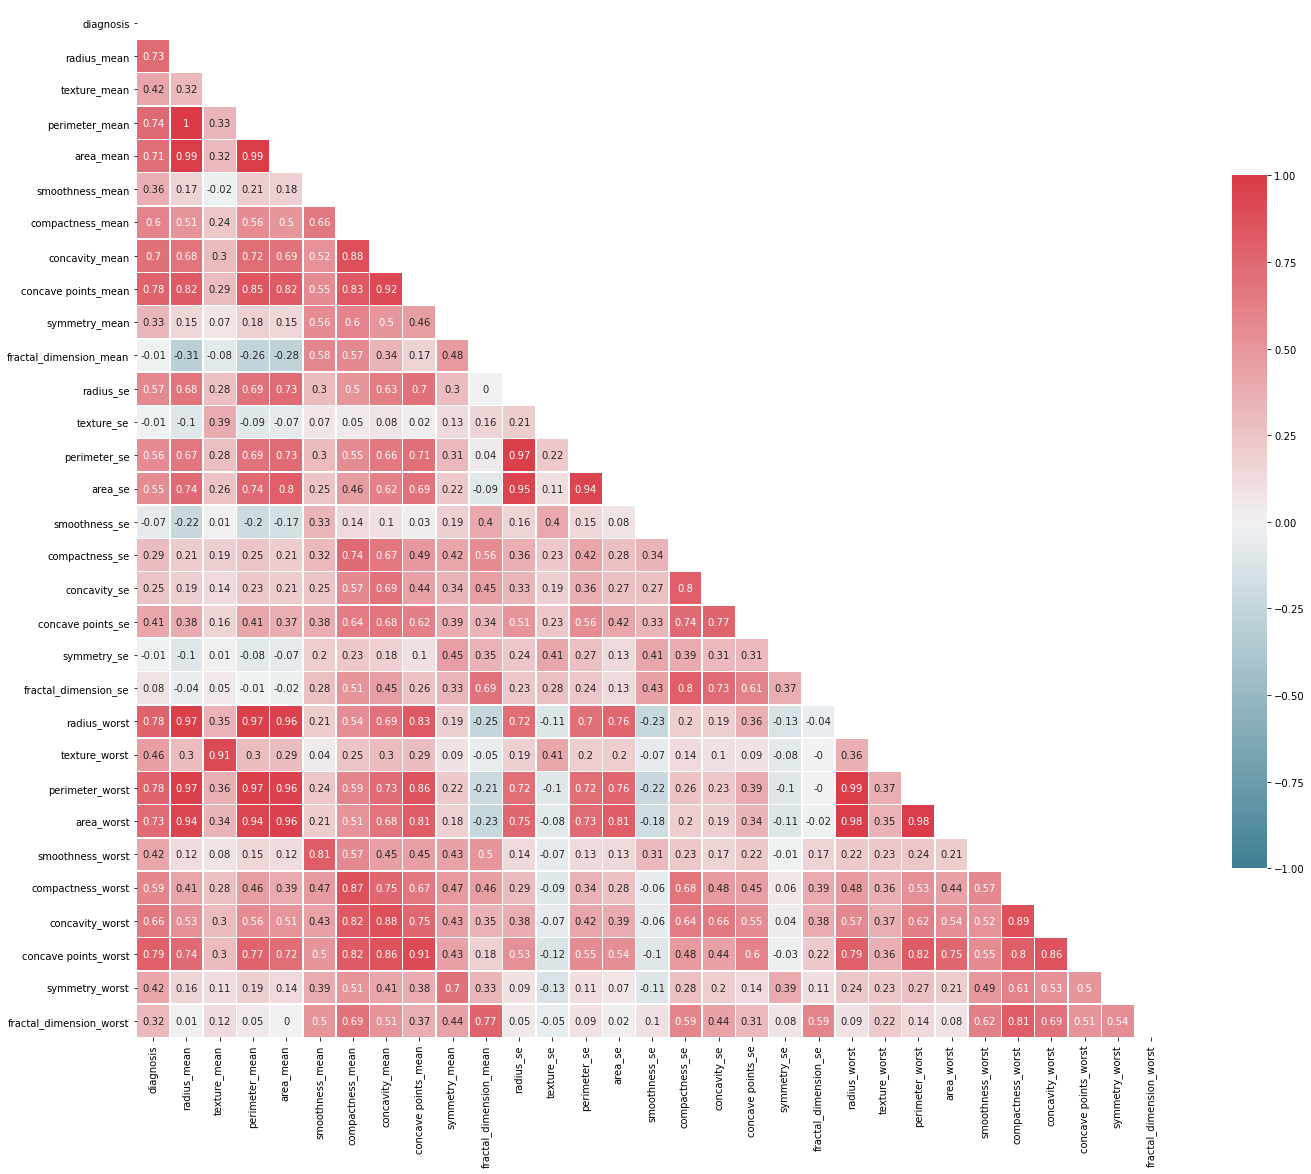

In [16]:
#5 Generate and visualize the correlation matrix
corr = data.corr().round(2)

# Mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.float32)
mask[np.triu_indices_from(mask)] = True

# Set figure size
f, ax = plt.subplots(figsize=(20, 20))

# Define custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

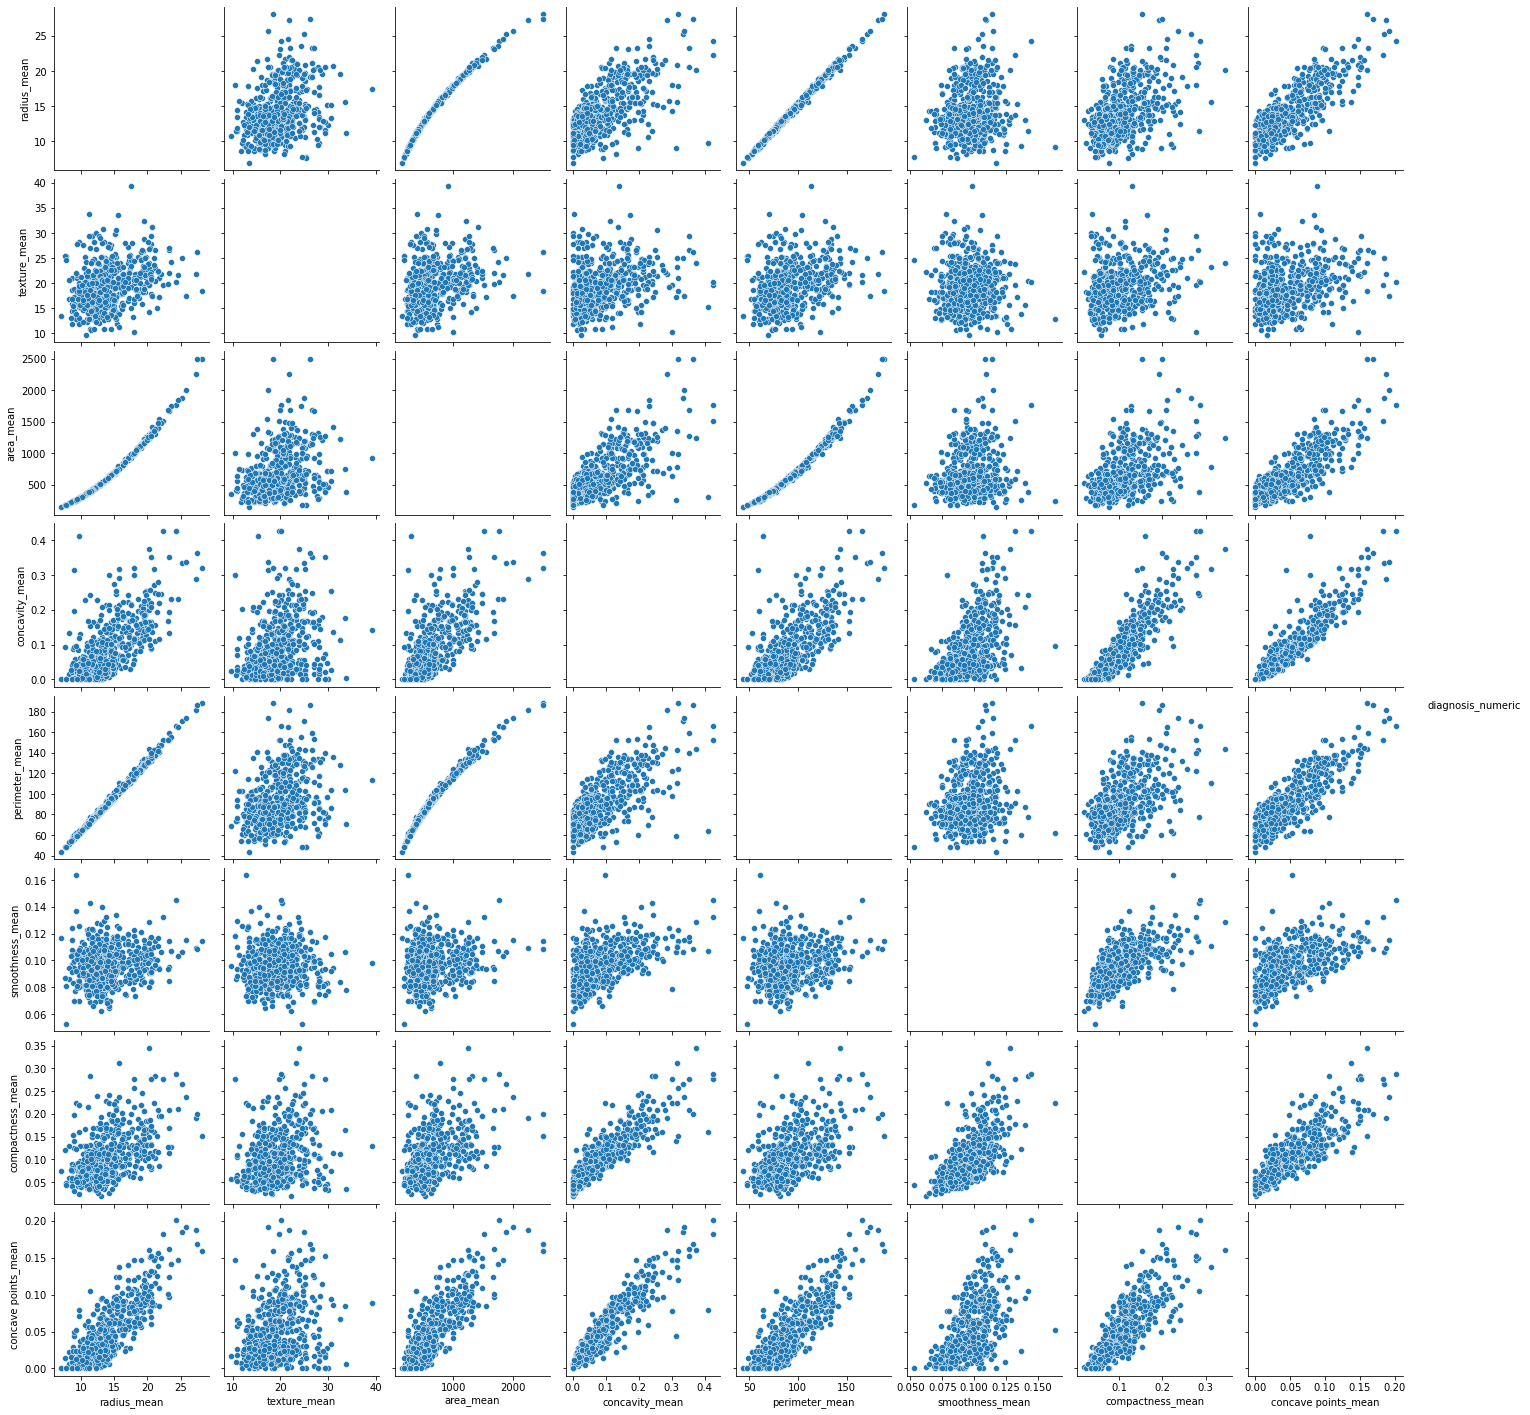

In [17]:
#6 Convert the 'diagnosis' column to numerical values: 1 for malignant ('M'), 0 for benign ('B')
data['diagnosis_numeric'] = data['diagnosis'].map({'M': 1, 'B': 0})

# Creating a scatter plot matrix (pair plot) using Seaborn, using the numeric diagnosis column for hue
sns.pairplot(data[features[:-1] + ['diagnosis_numeric']], hue='diagnosis_numeric', palette=['#ff9999', '#66b3ff'])

# Show the plot
plt.show()


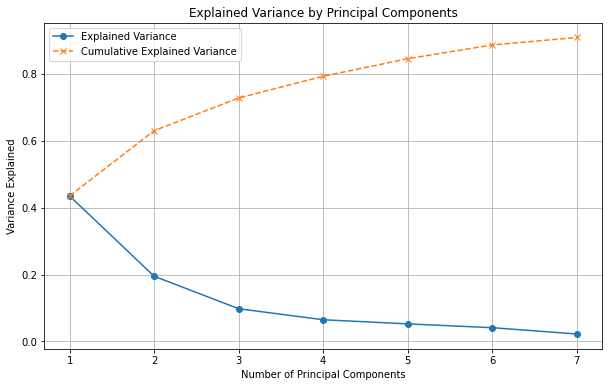

In [4]:
#7 Check the explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot the explained variance and cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='x', linestyle='--', label='Cumulative Explained Variance')

plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.legend()
plt.xticks(np.arange(1, len(explained_variance) + 1, step=1))
plt.show()

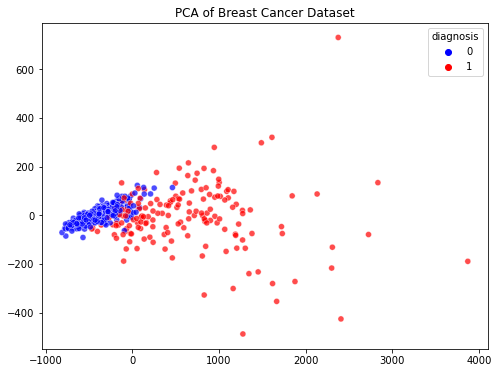

In [ ]:
# PCA
pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette=['blue', 'red'], alpha=0.7)
plt.title('PCA of Breast Cancer Dataset')
plt.show()

,feature,importance
23,area_worst,0.153892
27,concave points_worst,0.144663
7,concave points_mean,0.106210
20,radius_worst,0.077987
6,concavity_mean,0.068001
22,perimeter_worst,0.067115
2,perimeter_mean,0.053270
0,radius_mean,0.048703
3,area_mean,0.047555
26,concavity_worst,0.031802


<Figure size 1080x720 with 0 Axes>

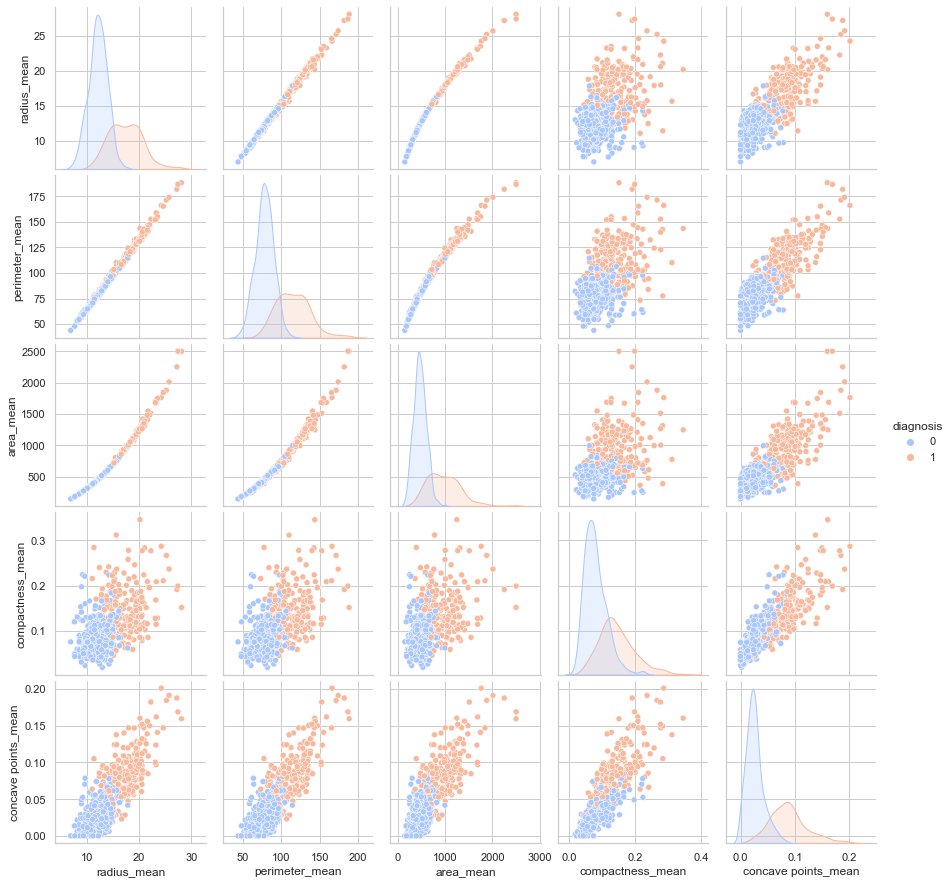

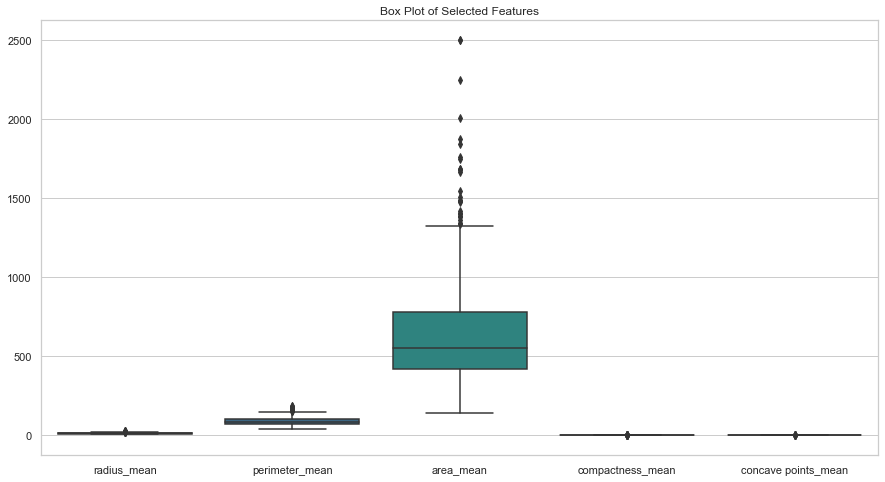

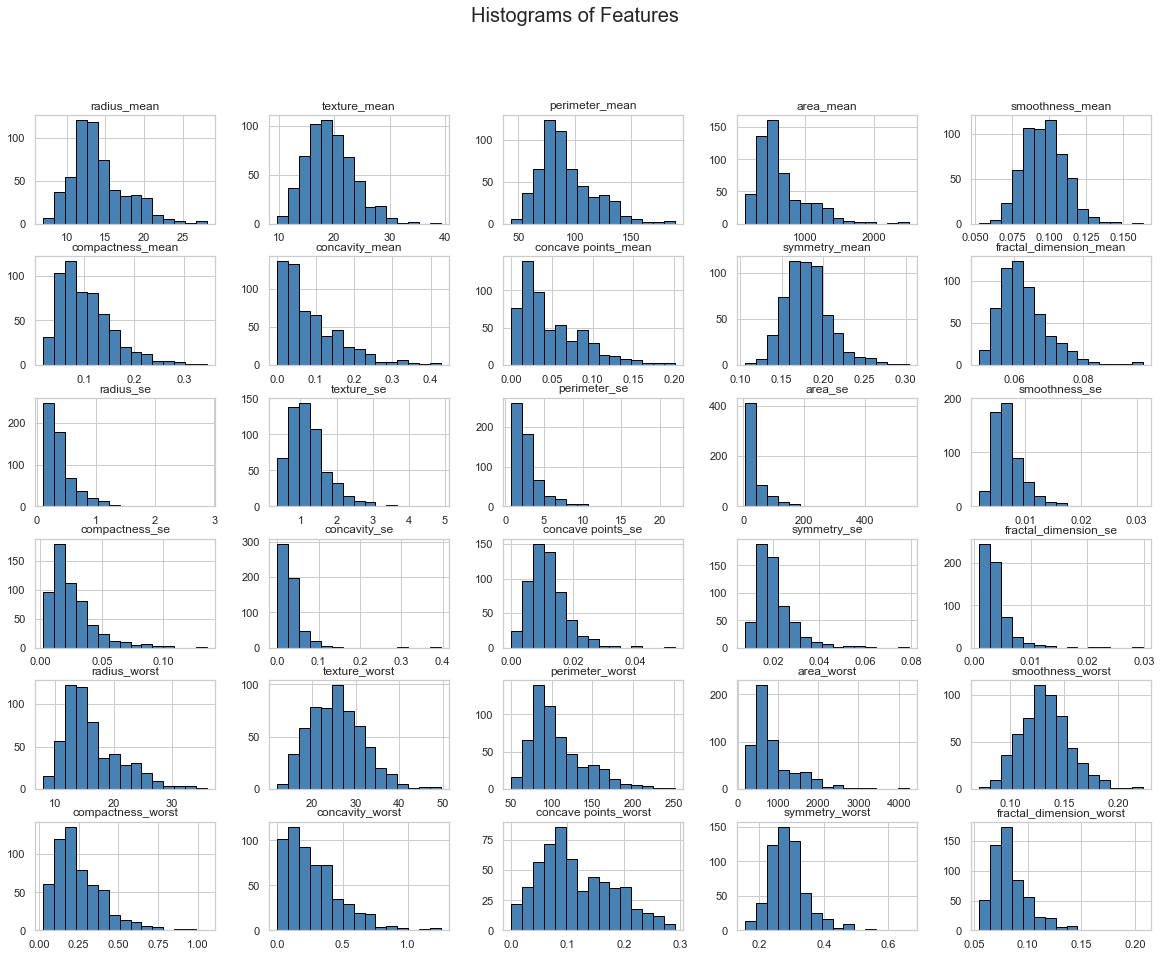

In [6]:
#9
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# 4. Visualization: Scatter Plot, Boxplot, and Histogram
# Set up the figure
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

# Pair Plot for selected features with high correlation to diagnosis
pair_plot_features = ['radius_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', 'concave points_mean', 'diagnosis']
pair_plot_data = data[pair_plot_features]
pair_plot = sns.pairplot(pair_plot_data, hue="diagnosis", palette="coolwarm")

# Box Plot for selected features
plt.figure(figsize=(15, 8))
box_plot_features = pair_plot_features[:-1]  # Exclude 'diagnosis'
sns.boxplot(data=data[box_plot_features], palette="viridis")
plt.title("Box Plot of Selected Features")

# Histogram of all features
X.hist(bins=15, figsize=(20, 15), color="steelblue", edgecolor="black")
plt.suptitle("Histograms of Features", fontsize=20)

# Display results
feature_importance.head(10)

<AxesSubplot:>

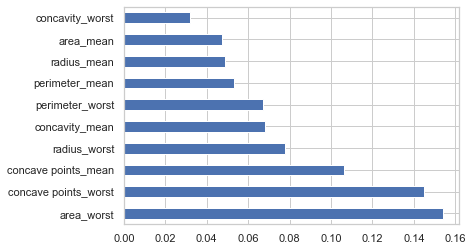

In [19]:
#feature importance with graphs
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(10).plot(kind='barh')

In [ ]:
# Define regularized model parameters
tuned_models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=4, min_samples_leaf=5),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=7, min_samples_leaf=4, random_state=42),
    "XGBoost": XGBClassifier(
    n_estimators=1000,         # High number to allow early stopping to kick in
    max_depth=2,               # Lower max depth to prevent overfitting
    learning_rate=0.05,        # Lower learning rate for gradual learning
    min_child_weight=4,        # Increase to make leaf nodes more robust
    subsample=0.8,             # Use a subset of the training data for each tree
    colsample_bytree=0.8,      # Use a subset of features for each tree
    reg_alpha=0.1,             # L1 regularization to penalize large weights
    reg_lambda=0.1,            # L2 regularization for weight decay
    use_label_encoder=False,   # Disable label encoding for binary classification
    eval_metric='logloss',     # Evaluation metric
    random_state=42
    ),
    "Histogram Gradient Boosting": HistGradientBoostingClassifier(
    max_iter=100,              # Reduce max iterations (can also try around 50-100)
    max_depth=3,               # Limit tree depth for less complexity
    min_samples_leaf=10,       # Require more samples per leaf to generalize better
    learning_rate=0.05,        # Lower learning rate for gradual updates
    l2_regularization=0.95,     # Add L2 regularization to prevent large weights
    random_state=42)
}

# Perform cross-validation and evaluate each model with updated regularization
tuned_metrics = {}
for name, model in tuned_models.items():
    # Train the model
    model.fit(X_train_pca, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train_pca)
    y_pred_prob_train = model.predict_proba(X_train_pca)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_train_pca)
    y_pred = model.predict(X_test_pca)
    y_pred_prob = model.predict_proba(X_test_pca)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test_pca)
    
    # Training and Test Metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test,y_pred)
    train_precision = precision_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred)
    train_roc_auc = auc(*roc_curve(y_train, y_pred_prob_train)[:2])
    test_roc_auc = auc(*roc_curve(y_test, y_pred_prob)[:2])
    conf_matrix = confusion_matrix(y_test, y_pred)
    
     # ROC curve and AUC for train and test data
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc_test = auc(fpr, tpr)
    
    # Store metrics
    tuned_metrics[name] = {
        "fpr" : fpr,
        "tpr": tpr,
        "confusion_matrix": conf_matrix,
        "roc_auc": roc_auc_test,
        "train accuracy": train_accuracy,
        "test accuracy": test_accuracy,
        "precision": precision,
        "train precison": train_precision,
        "cross-validation score": cross_val,
        "train f1": train_f1,
        "test f1": test_f1,
        "train roc_auc": train_roc_auc,
        "test roc_auc": test_roc_auc
    }

# Display the tuned metrics for comparison
for model_name, scores in tuned_metrics.items():
    print(f"Model: {model_name}")
    print(f"Test Accuracy: {scores['test accuracy']:.4f}")
    print(f"Train Accuracy: {scores['train accuracy']}")
    print(f"Precision: {scores['precision']:.4f}")
    print(f"Train Precision: {scores['train precison']:.4f}")
    print(f"Cross-Validation Score: {scores['cross-validation score']:.4f}")
    print(f"Test F1 Score: {scores['test f1']:.4f}")
    print(f"Train f1: {scores['train f1']:.4f}")
    print(f"Test ROC AUC: {scores['test roc_auc']:.4f}")
    print(f"Train ROC_AUC: {scores['train roc_auc']:.4f}")
    print("-" * 40)


c:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\

Model: Decision Tree
Test Accuracy: 0.9737
Train Accuracy: 0.9692307692307692
Precision: 0.9762
Train Precision: 0.9814
Cross-Validation Score: 0.9275
Test F1 Score: 0.9647
Train f1: 0.9576
Test ROC AUC: 0.9767
Train ROC_AUC: 0.9924
----------------------------------------
Model: Random Forest
Test Accuracy: 0.9561
Train Accuracy: 0.989010989010989
Precision: 0.9318
Train Precision: 1.0000
Cross-Validation Score: 0.9429
Test F1 Score: 0.9425
Train f1: 0.9850
Test ROC AUC: 0.9928
Train ROC_AUC: 0.9989
----------------------------------------
Model: XGBoost
Test Accuracy: 0.9737
Train Accuracy: 0.9934065934065934
Precision: 0.9545
Train Precision: 0.9940
Cross-Validation Score: 0.9692
Test F1 Score: 0.9655
Train f1: 0.9911
Test ROC AUC: 0.9934
Train ROC_AUC: 0.9994
----------------------------------------
Model: Histogram Gradient Boosting
Test Accuracy: 0.9649
Train Accuracy: 0.9912087912087912
Precision: 0.9333
Train Precision: 0.9940
Cross-Validation Score: 0.9582
Test F1 Score: 0.954

In [27]:
tuned_metrics

{'Decision Tree': {'fpr': array([0.        , 0.        , 0.        , 0.01408451, 0.05633803,
         0.08450704, 0.23943662, 0.90140845, 1.        ]),
  'tpr': array([0.        , 0.8372093 , 0.90697674, 0.95348837, 0.97674419,
         0.97674419, 0.97674419, 0.97674419, 1.        ]),
  'confusion_matrix': array([[70,  1],
         [ 2, 41]], dtype=int64),
  'roc_auc': 0.9767441860465115,
  'train accuracy': 0.9692307692307692,
  'test accuracy': 0.9736842105263158,
  'precision': 0.9761904761904762,
  'cross-validation score': 0.9274725274725274,
  'train f1': 0.9575757575757575,
  'test f1': 0.9647058823529412,
  'train roc_auc': 0.9924276906525428,
  'test roc_auc': 0.9767441860465115},
 'Random Forest': {'fpr': array([0.        , 0.        , 0.        , 0.01408451, 0.01408451,
         0.02816901, 0.02816901, 0.07042254, 0.07042254, 0.09859155,
         0.09859155, 1.        ]),
  'tpr': array([0.        , 0.02325581, 0.81395349, 0.81395349, 0.86046512,
         0.86046512, 0.9534

In [6]:
#sensitivity analysis FAST

#define problem
problem = {
    'num_vars': X_train_pca.shape[1],
    'names': [f'PC{i+1}' for i in range(X_train_pca.shape[1])],
    'bounds': [[X_train_pca[:, i].min(), X_train_pca[:, i].max()] for i in range(X_train_pca.shape[1])]
}


#making samples
param_values = fast_sampler(problem, 1000)  # Number of samples for sensitivity analysis

#predictions for each sampled input
predictions = model.predict_proba(param_values)[:, 1]

N = param_values.shape[0]
M = 4  

# Perform FAST sensitivity analysis
Si = fast.analyze(problem, predictions, M=M)



  Feature  Sensitivity (S1 Index)
0     PC1                0.596958
1     PC2                0.138468
4     PC5                0.055748
2     PC3                0.043884
3     PC4                0.011437
5     PC6                0.000313
6     PC7                0.000093


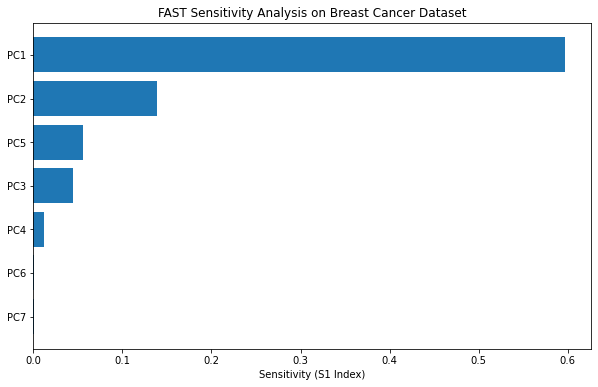

In [7]:
#Organize and display results
# Store results in a DataFrame for easy visualization
sensitivity_df = pd.DataFrame({
    'Feature': problem['names'],
    'Sensitivity (S1 Index)': Si['S1']
})

# Sort features by sensitivity
sensitivity_df.sort_values(by='Sensitivity (S1 Index)', ascending=False, inplace=True)

# Display the sensitivity DataFrame
print(sensitivity_df)

#Plot the sensitivities
plt.figure(figsize=(10, 6))
plt.barh(sensitivity_df['Feature'], sensitivity_df['Sensitivity (S1 Index)'])
plt.xlabel("Sensitivity (S1 Index)")
plt.title("FAST Sensitivity Analysis on Breast Cancer Dataset")
plt.gca().invert_yaxis()
plt.show()

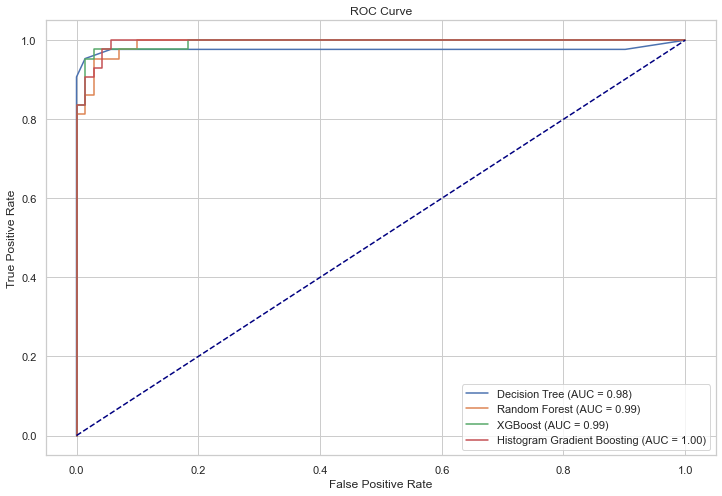

In [21]:
# Plot ROC Curves
plt.figure(figsize=(12, 8))
for name, metric in tuned_metrics.items():
    plt.plot(metric["fpr"], metric["tpr"], label=f"{name} (AUC = {metric['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

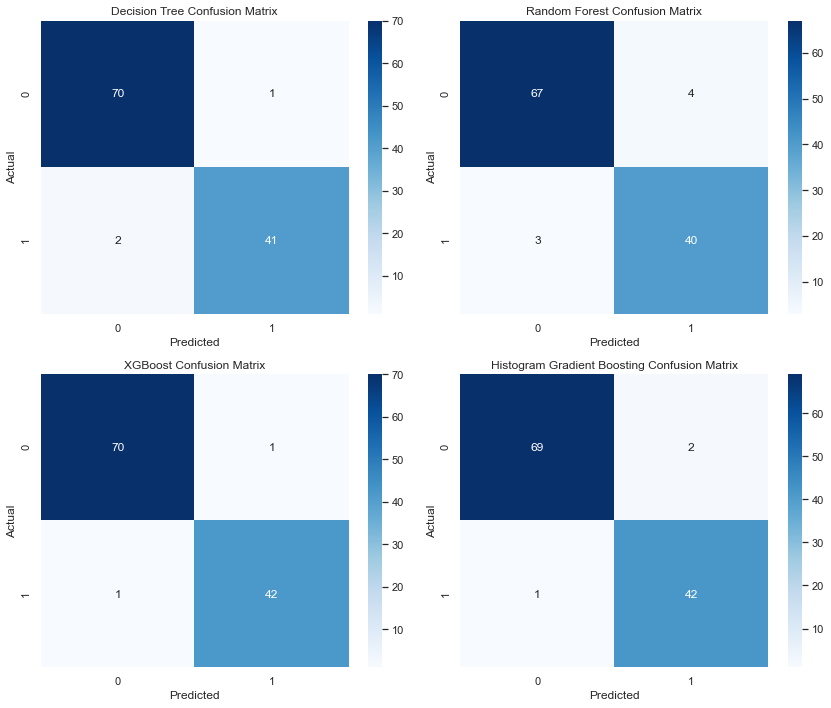

In [29]:
# Model performance data
results = {
    'Decision Tree': {'accuracy': 0.9737, 'precision': 0.9762,'cross_validation_score':0.9275, 'f1_score': 0.9647,
                      'confusion_matrix': np.array([[70, 1], [2, 41]]), 'fpr': [0.0, 0.04225352, 1.0],
                      'tpr': [0.0, 0.93023256, 1.0], 'roc_auc': 0.9767},
    'Random Forest': {'accuracy': 0.9561, 'precision': 0.9318,'cross_validation_score':0.9429, 'f1_score': 0.9425,
                      'confusion_matrix': np.array([[67, 4], [3, 40]]), 'fpr': [0.0, 0.01408451, 0.74647887, 1.0],
                      'tpr': [0.0, 0.41860465, 0.81395349, 1.0], 'roc_auc': 0.9928},
    'XGBoost': {'accuracy': 0.9737, 'precision': 0.9545,'cross_validation_score': 0.9692, 'f1_score': 0.9655,
                'confusion_matrix': np.array([[70, 1], [1, 42]]), 'fpr': [0.0, 0.01408451, 1.0],
                'tpr': [0.0, 0.97674419, 1.0], 'roc_auc': 0.9934},
    'Histogram Gradient Boosting': {'accuracy': 0.9649, 'precision': 0.9333,'cross_validation_score': 0.9582, 'f1_score': 0.9545,
                                    'confusion_matrix': np.array([[69, 2], [1, 42]]), 'fpr': [0.0, 0.01408451, 1.0],
                                    'tpr': [0.0, 0.97674419, 1.0], 'roc_auc': 0.9951}
}

# Plot Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for ax, (model, res) in zip(axes, results.items()):
    sns.heatmap(res['confusion_matrix'], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{model} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()


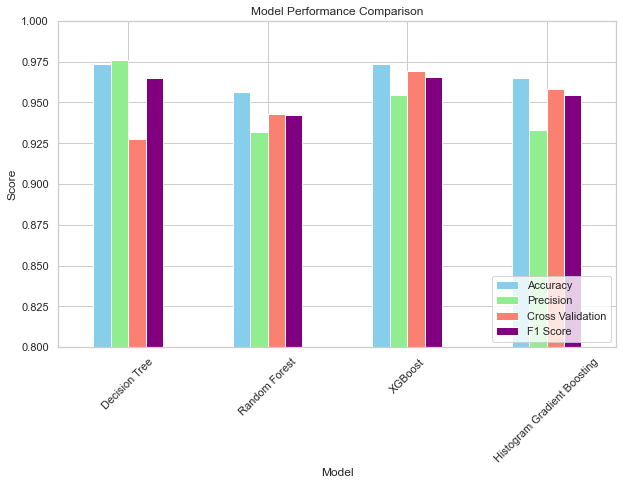

In [30]:
# Prepare DataFrames for Metric Bar Plots
metrics_summary = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": [res["accuracy"] for res in results.values()],
    "Precision": [res["precision"] for res in results.values()],
    "Cross Validation": [res["cross_validation_score"] for res in results.values()],
    "F1 Score": [res["f1_score"] for res in results.values()],
    "AUC": [res["roc_auc"] for res in results.values()]
}).set_index("Model")

# Plot Metric Comparison (Accuracy, Precision, F1 Score)
metrics_summary[['Accuracy', 'Precision','Cross Validation', 'F1 Score']].plot(kind='bar', figsize=(10, 6), color=["skyblue", "lightgreen", "salmon","purple"])
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)
plt.legend(loc="lower right")
plt.show()

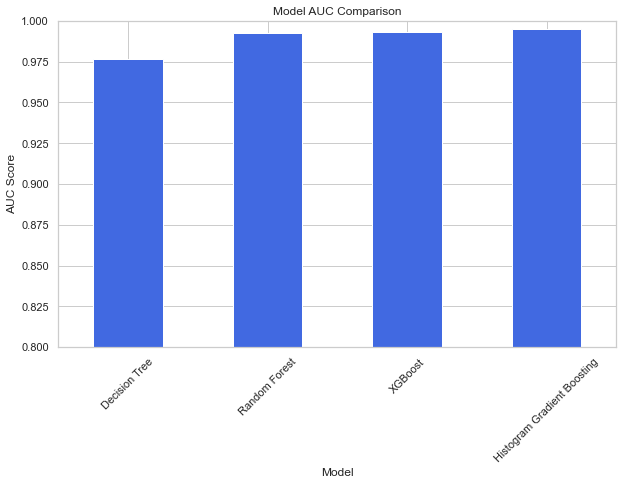

In [31]:
# Plot AUC Comparison
metrics_summary['AUC'].plot(kind='bar', figsize=(10, 6), color="royalblue")
plt.title("Model AUC Comparison")
plt.ylabel("AUC Score")
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)
plt.show()


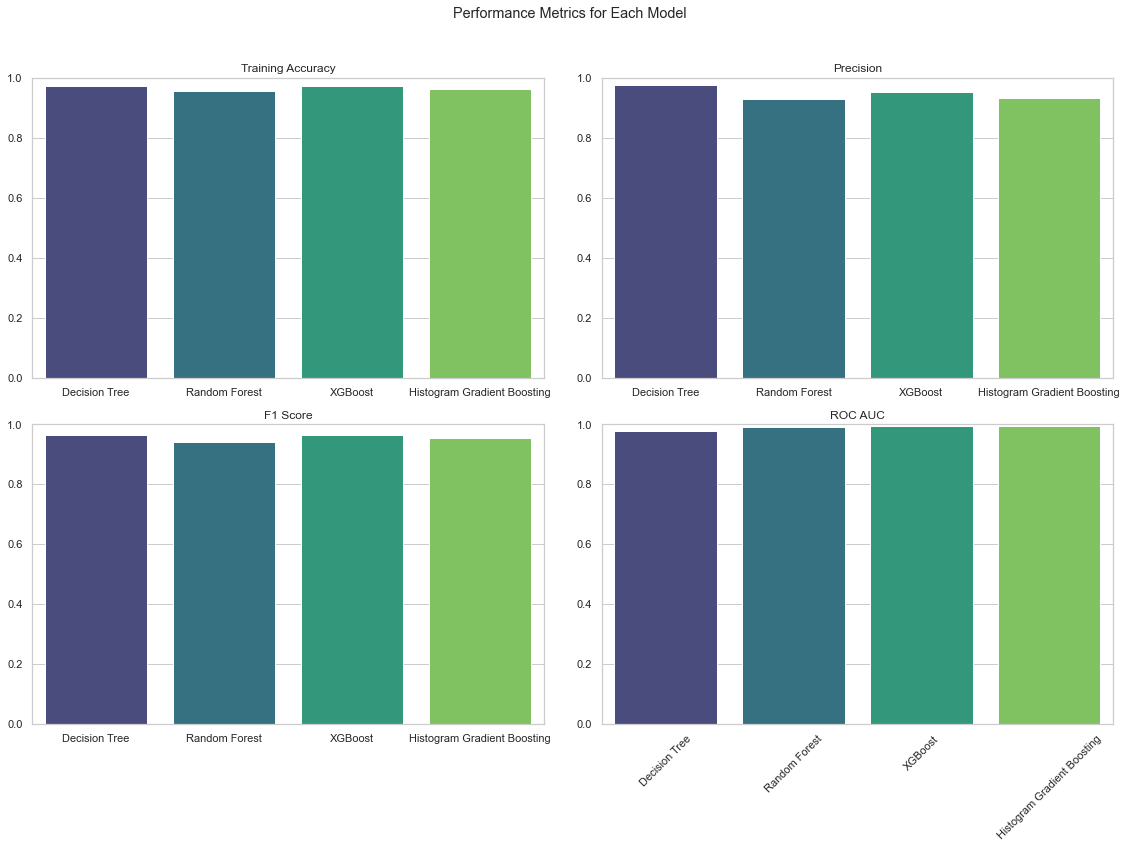

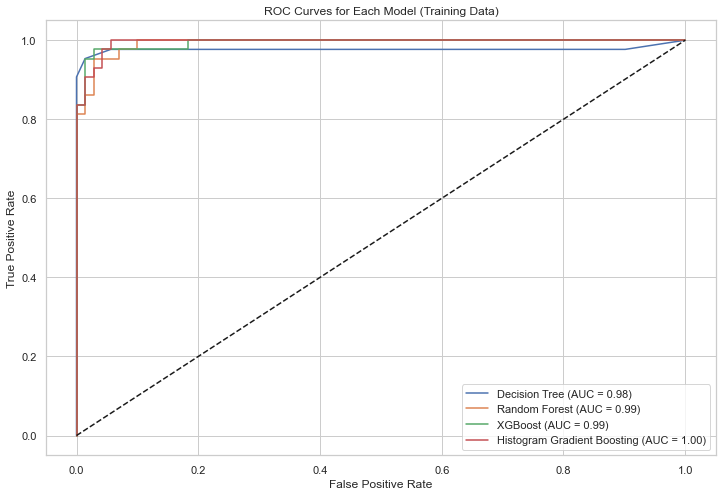

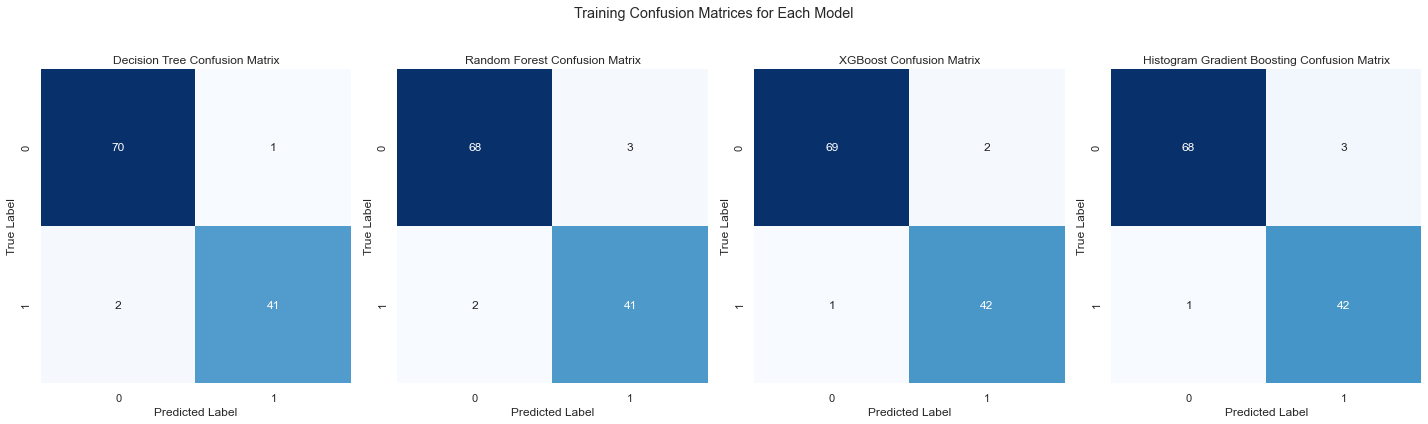

In [34]:
# Set plot style
sns.set(style="whitegrid")
models = list(tuned_metrics.keys())

# Extract train metrics from `metrics` dictionary
train_accuracy = [tuned_metrics[model]["test accuracy"] for model in models]
train_precision = [tuned_metrics[model]["precision"] for model in models]
train_f1 = [tuned_metrics[model]["test f1"] for model in models]
train_roc_auc = [tuned_metrics[model]["roc_auc"] for model in models]

# Plot accuracy, precision, F1 score, and ROC AUC
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Performance Metrics for Each Model")

# Accuracy
sns.barplot(x=models, y=train_accuracy, ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title("Training Accuracy")
axes[0, 0].set_ylim(0, 1)

# Precision
sns.barplot(x=models, y=train_precision, ax=axes[0, 1], palette="viridis")
axes[0, 1].set_title("Precision")
axes[0, 1].set_ylim(0, 1)

# F1 Score
sns.barplot(x=models, y=train_f1, ax=axes[1, 0], palette="viridis")
axes[1, 0].set_title("F1 Score")
axes[1, 0].set_ylim(0, 1)

# ROC AUC
sns.barplot(x=models, y=train_roc_auc, ax=axes[1, 1], palette="viridis")
axes[1, 1].set_title("ROC AUC")
axes[1, 1].set_ylim(0, 1)

plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plot ROC curves
plt.figure(figsize=(12, 8))
for model in models:
    fpr = tuned_metrics[model]["fpr"]
    tpr = tuned_metrics[model]["tpr"]
    plt.plot(fpr, tpr, label=f'{model} (AUC = {tuned_metrics[model]["test roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Model (Training Data)")
plt.legend()
plt.show()

# Plot Confusion Matrices
fig, axes = plt.subplots(1, len(models), figsize=(20, 6))
fig.suptitle("Training Confusion Matrices for Each Model")

for i, model in enumerate(models):
    conf_mat = tuned_metrics[model]["confusion_matrix"]
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
    axes[i].set_title(f'{model} Confusion Matrix')
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [35]:
# Detailed Metrics Table
detailed_metrics = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": [res["accuracy"] for res in results.values()],
    "Precision": [res["precision"] for res in results.values()],
    "Cross Validation": [res["cross_validation_score"] for res in results.values()],
    "Recall": [res["f1_score"] / (2 * res["precision"] - res["f1_score"]) for res in results.values()],
    "F1 Score": [res["f1_score"] for res in results.values()],
    "AUC": [res["roc_auc"] for res in results.values()]
}).set_index("Model")

print("Detailed Metrics Table:")
display(detailed_metrics)

# Confusion Matrix Table
conf_matrix_table = pd.DataFrame({
    "Model": list(results.keys()),
    "True Positives": [res['confusion_matrix'][1, 1] for res in results.values()],
    "True Negatives": [res['confusion_matrix'][0, 0] for res in results.values()],
    "False Positives": [res['confusion_matrix'][0, 1] for res in results.values()],
    "False Negatives": [res['confusion_matrix'][1, 0] for res in results.values()]
}).set_index("Model")

print("\nConfusion Matrix Table:")
display(conf_matrix_table)

# Precision-Recall Table
pr_table = pd.DataFrame({
    "Model": list(results.keys()),
    "Average Precision": [precision_recall_data[model]["pr_auc"] for model in results.keys()],
    "Average Recall": [res["f1_score"] / (2 * res["precision"] - res["f1_score"]) for res in results.values()],
}).set_index("Model")

print("\nPrecision-Recall Table:")
display(pr_table)

Detailed Metrics Table:


,Accuracy,Precision,Cross Validation,Recall,F1 Score,AUC
Model,,,,,,
Decision Tree,0.9737,0.9762,0.9275,0.976714,0.9647,0.9767
Random Forest,0.9561,0.9318,0.9429,1.023233,0.9425,0.9928
XGBoost,0.9737,0.9545,0.9692,1.023317,0.9655,0.9934
Histogram Gradient Boosting,0.9649,0.9333,0.9582,1.046486,0.9545,0.9951



Confusion Matrix Table:


,True Positives,True Negatives,False Positives,False Negatives
Model,,,,
Decision Tree,41,70,1,2
Random Forest,40,67,4,3
XGBoost,42,70,1,1
Histogram Gradient Boosting,42,69,2,1


NameError: name 'precision_recall_data' is not defined